# Experimental Configuration

## Confocal Controls 

In [9]:
from NV_ABJ import NiDaqSingleAxisScanner

confocal_x = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot5",
                                              channel_name_output="ao0",
                                              position_limits_m=(-50e-6,50e-6))

confocal_y = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot5",
                                              channel_name_output="ao1",
                                              position_limits_m=(-50e-6,50e-6))


confocal_z = NiDaqSingleAxisScanner(conversion_volts_per_meter_setting=10/(50e-6),
                                              device_name_output="PXI1Slot4",
                                              channel_name_output="ao3",
                                              position_limits_m=(-50e-6,50e-6))

# Setting the default locations to 0

with confocal_x, confocal_y, confocal_z:
    confocal_x.set_position_m(0)
    confocal_y.set_position_m(0)
    confocal_z.set_position_m(0)

## Photon Counter

In [11]:
from NV_ABJ import NiPhotonCounterDaqControlled
photon_counter = NiPhotonCounterDaqControlled(device_name="PXI1Slot3",
                                                counter_pfi="pfi0",
                                                trigger_pfi="pfi2")

## Sequence Generation Controls 

In [5]:
from NV_ABJ.hardware_interfaces.sequence_generation.spbicl_pulse_blaster.SpbiclPulseBlaster import SpbiclPulseBlaster
from NV_ABJ import SequenceDevice

sequence_generator = SpbiclPulseBlaster()

microwave_switch = SequenceDevice(address=0,
                                  device_label="Microwaves")

apd_trigger = SequenceDevice(address=1,
                             device_label="APD")

aom_trigger = SequenceDevice(address=2,
                             device_label="AOM")

## Signal Generation

In [6]:
from NV_ABJ import SG380

srs_address = 'GPIB0::27::INSTR'
signal_generator_1 = SG380(gpib_address=srs_address)

# Confocal Scanning 

In [12]:
# basic Imports
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

class ConfocalControls:
    def __init__(self,scanner_x,scanner_y,scanner_z,photon_counter):
        self.scanner_x = scanner_x
        self.scanner_y = scanner_y
        self.scanner_z = scanner_z
        self.photon_counter = photon_counter


    def xy_scan(self,dwell_time_s,x_positions,y_positions,z_position):
        print(f"Time Estimate (min): {2*dwell_time_s*len(x_positions)*len(y_positions)/60}, Started at: {datetime.fromtimestamp(time.time())}")


        x_length = len(y_positions)
        xy_counts = np.zeros((x_length,len(y_positions)))
        line_counts = np.zeros(x_length)
        reversed_x = x_positions[::-1]
    
        # Getting original z to return to 
        z_original = self.scanner_z._position_m

        with self.scanner_x as x_con, self.scanner_y as y_con, self.scanner_z as z_con, self.photon_counter as pc:
            # Sets the initial position to be location at the place that the user requested
            z_con.set_position_m(z_position)

            # Iterates through y setting the position once per line 
            for ind_y,y_loc in enumerate(y_positions):
                y_con.set_position_m(y_loc)

                # Flips the even and odd rows so we don't have jumps going back and forth on the x axis 
                if ind_y%2 == 0:
                    for ind_x,x_loc in enumerate(x_positions):
                        x_con.set_position_m(x_loc)
                        counts = pc.get_counts_per_second(dwell_time_s=dwell_time_s)
                        line_counts[ind_x] = counts

                else:
                    for ind_x,x_loc in enumerate(reversed_x):
                        x_con.set_position_m(x_loc)
                        counts = pc.get_counts_per_second(dwell_time_s=dwell_time_s)
                        line_counts[(x_length-1)-ind_x] = counts

                # Adds a full line at a time 
                xy_counts[:,ind_y] = line_counts
            
            # Resetting back to original z position
            z_con.set_position_m(z_original)
        
        return xy_counts
    
    def z_scan(self,dwell_time_s,x_position,y_position, z_positions,photon_counter):
        photon_counts = np.zeros(len(z_positions))

        # Getting original z to return to 
        z_original = self.scanner_z._position_m

        print(f"Estimated Time (min){2*dwell_time_s*len(z_positions)/60}")

        with confocal_x, confocal_y, confocal_z, photon_counter as pc:
            confocal_x.set_position_m(x_position)
            confocal_y.set_position_m(y_position)

            for ind_z,z_loc in enumerate(z_positions):
                confocal_z.set_position_m(z_loc)
                photon_counts[ind_z] = pc.get_counts_raw(dwell_time_s)

            # Resetting back to original z position
            confocal_z.set_position_m(z_original)
        
        return photon_counts
    

confocal = ConfocalControls(confocal_x,confocal_y,confocal_z,photon_counter)

# Turning On Pulse Blaster Bits 

In [18]:
# Just turning on these devices 
sequence_generator.stop()

microwave_switch.device_status = False
apd_trigger.device_status = False
aom_trigger.device_status = True

sequence_generator.update_devices([microwave_switch,apd_trigger,aom_trigger])


0

# Making a 2D scan

## Getting the Image Data 

In [13]:
dwell_time_s = 30e-3

z_position = -10e-6
x_positions = np.linspace(-38e-6,-28e-6,50)
y_positions = np.linspace(-32e-6,-20e-6,50)

xy_counts = confocal.xy_scan(dwell_time_s,x_positions,y_positions,z_position)

Time Estimate (min): 2.5, Started at: 2025-03-31 16:38:01.010065


## Graphing Image Scan

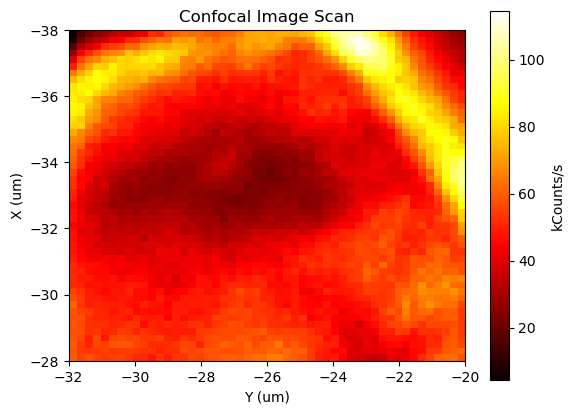

In [14]:
img = plt.imshow(xy_counts/1000, cmap='hot', extent=(min(y_positions)*1e6,max(y_positions)*1e6,max(x_positions)*1e6,min(x_positions)*1e6))  # Use a colormap for visualization
cbar = plt.colorbar(img)
#plt.clim(2.25,13.25)
cbar.set_label("kCounts/s")


plt.title("Confocal Image Scan")
plt.xlabel("Y (um)")
plt.ylabel("X (um)")
plt.show()


# Making a Z Scan

## Getting the Z Scan Data

In [20]:
dwell_time_s = 50e-3

x_position = -33e-6
y_position = -27.5e-6
number_of_positions = 200
z_positions = np.linspace(-50e-6,50e-6,number_of_positions)

z_scan = confocal.z_scan(dwell_time_s,x_position,y_position,z_positions,photon_counter)

Estimated Time (min)0.3333333333333333


## Graphing the Z Scan Data 

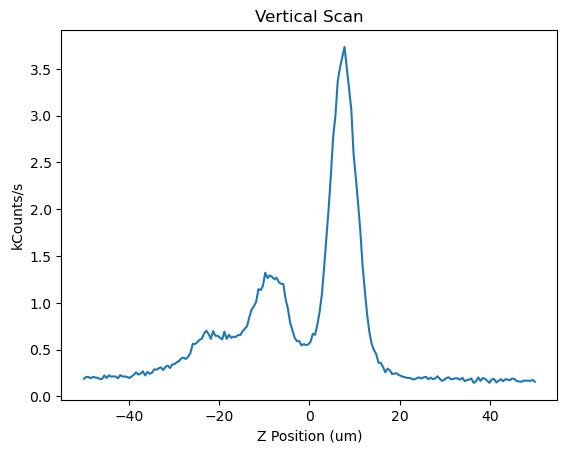

In [21]:
plt.plot(z_positions*1e6,z_scan/1000)
plt.title("Vertical Scan")
plt.xlabel("Z Position (um)")
plt.ylabel("kCounts/s")
plt.show()